# **Uncovering Hidden Crime Patterns in Mexico City: A Data-Driven Strategy Proposal Using Machine Learning Unsupervised Learning**

## **Project Overview**
This data science project analyzes records of crime victims documented in investigation files by the Mexico City Attorney General's Office (FGJCDMX) since January 2019. Mexico City, one of the most densely populated cities in the world, has approximately 9.2 million residents within the city limits and over 21 million in the greater metropolitan area, resulting in complex public safety challenges (Instituto Nacional de Estadistica y Geografia [INEGI], 2020).

The data from FGJCDMX provides an updated view of crime victims across various offenses in the city, offering a robust foundation for identifying trends and patterns related to public safety.

The purpose of this analysis is to support authorities and the community by promoting data-driven, informed decision-making that contributes to reducing crime rates and enhancing the safety and quality of life in the city.

#### **Motivation**
Analyzing data on crime victims is critical for understanding and addressing public safety issues in a city as large and diverse as Mexico City. The city experiences considerable variations in crime types and frequencies across its boroughs, with areas like Iztapalapa and Cuauhtemoc frequently reporting high crime rates due to dense populations and commercial activity (Secretaria de Seguridad Ciudadana de la Ciudad de Mexico [SSC CDMX], 2021). This project utilizes FGJCDMX records to identify crime patterns and high-incidence areas, aiming to strengthen prevention and response strategies across the city. The findings are intended as a valuable resource for authorities in designing effective public safety policies and for the public, promoting awareness and a data-informed culture of protection.


#### **Data source**
The data was sourced from the official open data portal of Mexico City
Mexico City Government. Victimas en carpetas de investigacion - FGJ. Open Data CDMX. Retrieved October 29, 2024, from https://datos.cdmx.gob.mx/dataset/victimas-en-carpetas-de-investigacion-fgj

**Dataset Overview:**

Occurrence Date (fecha_hecho): The date when the crime took place.
Investigation Start Date (fecha_inicio): The date the investigation file was opened.
Victim’s Gender: Includes the recorded gender and other details of the victim.
Clarifications: It is noted that the victim is not always the reporting party and a single investigation file may include multiple victims.

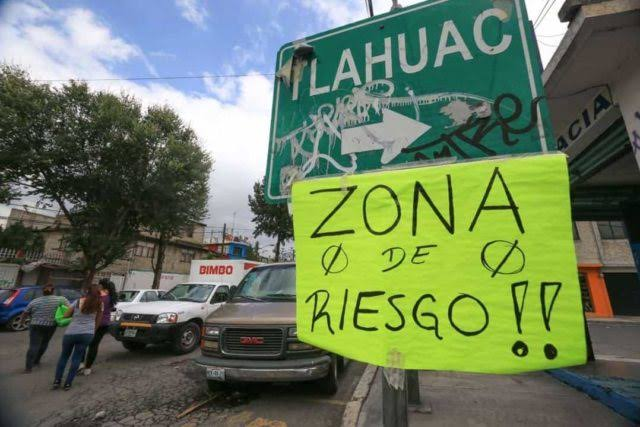

#### **References**
- Instituto Nacional de Estadistica y Geografia. (2020). **Censo de Poblacion y Vivienda 2020**. INEGI. Retrieved from [https://www.inegi.org.mx](https://www.inegi.org.mx)
- Secretaria de Seguridad Ciudadana de la Ciudad de Mexico. (2021). **Reporte Anual de Incidencia Delictiva en la Ciudad de Mexico**. SSC CDMX. Retrieved from [https://www.ssc.cdmx.gob.mx](https://www.ssc.cdmx.gob.mx)





## Data Extraction
Raw data from FGJ is ingested from the open data portal

In [ ]:
# Libraries needed

# Data manipulation and handling
import numpy as np
import pandas as pd
from datetime import date

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Clustering and machine learning
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import silhouette_score

# Geospatial visualization
import folium
from folium.plugins import MarkerCluster, HeatMap

# Warnings and display settings
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

c:\Users\v1cto\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
# Data reading path
csv_path = '../FGJ_data.csv'
crime_data = pd.read_csv(csv_path)

# Select the columns for the study
crime_data = crime_data[[
        'anio_inicio', 'mes_inicio', 'fecha_inicio',
        'anio_hecho', 'mes_hecho', 'fecha_hecho',
        'hora_hecho', 'delito','sexo',
        'edad','tipo_persona', 'calidad_juridica',
       'colonia_hecho','alcaldia_hecho',
       'latitud', 'longitud']]

# First glance of the database
print(f'Shape of the dataset: {crime_data.shape}, size of the dataset: {crime_data.size}')
crime_data.sample(5)

Shape of the dataset: (1415763, 16), size of the dataset: 22652208


anio_inicio mes_inicio fecha_inicio  anio_hecho  mes_hecho  \
633879        2022.0      Abril   2022-04-29      2022.0      Abril   
1229628       2024.0      Enero   2024-01-02      2023.0  Diciembre   
387776        2020.0  Diciembre   2020-12-24      2020.0  Diciembre   
112754        2019.0      Abril   2019-04-12      2018.0      Abril   
1371744       2024.0      Julio   2024-07-25      2024.0      Julio   

        fecha_hecho hora_hecho  \
633879   2022-04-29   13:52:00   
1229628  2023-12-26   20:30:00   
387776   2020-12-24   14:11:00   
112754   2018-04-07   09:30:00   
1371744  2024-07-23   16:05:00   

                                                    delito       sexo  edad  \
633879                          ROBO DE ACCESORIOS DE AUTO  Masculino  37.0   
1229628           LESIONES CULPOSAS POR TRANSITO VEHICULAR   Femenino  26.0   
387776   DAÑO EN PROPIEDAD AJENA CULPOSA POR TRÁNSITO V...  Masculino  35.0   
112754      ROBO A TRANSEUNTE EN VIA PUBLICA CON VIOLENCIA  Masculino   NaN   
1371744                  ROBO DE MOTOCICLETA SIN VIOLENCIA   Femenino  27.0   

        tipo_persona       calidad_juridica       colonia_hecho  \
633879        FISICA  VICTIMA Y DENUNCIANTE             ANAHUAC   
1229628       FISICA              LESIONADO        LAS AMÉRICAS   
387776        FISICA  VICTIMA Y DENUNCIANTE  VILLA PANAMERICANA   
112754        FISICA  VICTIMA Y DENUNCIANTE                 NaN   
1371744       FISICA  DENUNCIANTE Y VICTIMA    SAN PEDRO MÁRTIR   

         alcaldia_hecho    latitud   longitud  
633879   MIGUEL HIDALGO  19.440532 -99.181760  
1229628      IZTAPALAPA  19.360017 -99.061807  
387776         COYOACAN  19.306558 -99.170344  
112754    FUERA DE CDMX        NaN        NaN  
1371744         TLALPAN  19.267280 -99.170821

## Data Wrangling
Data Cleaning:
Remove duplicates, handle missing values, and standardize column formats to ensure consistency and reliability.

Formatting and Standardization:
Dates and other time-based fields were reformatted for uniformity, and categorical values were standardized for proper analysis and visualization.

Feature Engineering:
Create additional features to enhance the dataset’s analytical depth and relevance.

New Features:
Relevant features were derived to capture key insights from the data, to better align with the study objectives.

In [ ]:
# Renaming columns in English
crime_data.rename(columns={
    'anio_inicio': 'investigation_report_year',
    'mes_inicio': 'investigation_report_month',
    'fecha_inicio': 'investigation_report_date',
    'anio_hecho': 'incident_year',
    'mes_hecho': 'incident_month',
    'fecha_hecho': 'incident_date',
    'hora_hecho': 'incident_time',
    'delito': 'crime',
    'sexo': 'gender',
    'edad': 'age',
    'tipo_persona': 'person_type',
    'calidad_juridica': 'legal_status',
    'colonia_hecho': 'incident_neighborhood',
    'alcaldia_hecho': 'incident_borough',
    'latitud': 'latitude',
    'longitud': 'longitude'
}, inplace=True)




# Data tipes of the dataset
print(crime_data.dtypes)


investigation_report_year     float64
investigation_report_month     object
investigation_report_date      object
incident_year                 float64
incident_month                 object
incident_date                  object
incident_time                  object
crime                          object
gender                         object
age                           float64
person_type                    object
legal_status                   object
incident_neighborhood          object
incident_borough               object
latitude                      float64
longitude                     float64
dtype: object


*Lets focus on the top 10 most commited crimes*

In [ ]:
# Get the top 10 most frequent crimes
top_10_crimes = crime_data['crime'].value_counts().head(10)

# Filter the DataFrame to include only the top 10 most frequent crimes
crime_data = crime_data[crime_data['crime'].isin(top_10_crimes.index)]

crime_data.crime.unique()

array(['FRAUDE', 'ROBO DE ACCESORIOS DE AUTO', 'ROBO DE OBJETOS',
       'ABUSO DE CONFIANZA', 'AMENAZAS', 'ROBO A NEGOCIO SIN VIOLENCIA',
       'ROBO A TRANSEUNTE EN VIA PUBLICA CON VIOLENCIA',
       'ROBO DE OBJETOS DEL INTERIOR DE UN VEHICULO',
       'USURPACIÓN DE IDENTIDAD', 'VIOLENCIA FAMILIAR'], dtype=object)

In [ ]:
# Column value translation for each that appears in spanish

# First with the month columns that share the same values
month_translation = {
    "Enero": "January", "Febrero": "February", "Marzo": "March",
    "Abril": "April", "Mayo": "May", "Junio": "June",
    "Julio": "July", "Agosto": "August", "Septiembre": "September",
    "Octubre": "October", "Noviembre": "November", "Diciembre": "December"
}

# Apply the dictionary to both columns for the month incidents
crime_data['investigation_report_month'] = crime_data['investigation_report_month'].map(month_translation).fillna(crime_data['investigation_report_month'])
crime_data['incident_month'] = crime_data['incident_month'].map(month_translation).fillna(crime_data['incident_month'])


# Gender translation
crime_data['gender'] = crime_data['gender'].map({
    "Masculino": "Male", "Femenino": "Female"
}).fillna(crime_data['gender'])

# Person type translation
crime_data['person_type'] = crime_data['person_type'].map({
    "FISICA": "Individual", "MORAL": "Legal Entity"
}).fillna(crime_data['person_type'])

# Legal status translation
crime_data['legal_status'] = crime_data['legal_status'].map({
    "OFENDIDO": "Victim", "VICTIMA Y DENUNCIANTE": "Victim and Complainant",
    "DENUNCIANTE": "Complainant", "IMPUTADO": "Accused", "TESTIGO": "Witness"
}).fillna(crime_data['legal_status'])

# Top ten crimes transaltion in english
crime_data['crime'] = crime_data['crime'].map({
    'FRAUDE': 'Fraud',
    'ROBO DE VEHICULO DE SERVICIO PARTICULAR SIN VIOLENCIA': 'Theft of Private Vehicle without Violence',
    'ROBO DE ACCESORIOS DE AUTO': 'Theft of Car Accessories',
    'ROBO DE OBJETOS': 'Theft of Objects',
    'AMENAZAS': 'Threats',
    'ROBO A TRANSEUNTE EN VIA PUBLICA CON VIOLENCIA': 'Robbery of Pedestrian in Public with Violence',
    'ROBO DE OBJETOS DEL INTERIOR DE UN VEHICULO': 'Theft of Items from Inside a Vehicle',
    'USURPACIÓN DE IDENTIDAD': 'Identity Theft',
    'VIOLENCIA FAMILIAR': 'Domestic Violence',
    'ABUSO SEXUAL': 'Sexual Abuse',
    'ABUSO DE CONFIANZA': 'Breach of Trust',
    'ROBO A NEGOCIO SIN VIOLENCIA': 'Theft from Business without Violence'
}).fillna(crime_data['crime'])

In [ ]:
crime_data.head()

investigation_report_year investigation_report_month  \
0                      2019.0                    January   
12                     2019.0                    January   
14                     2019.0                    January   
15                     2019.0                    January   
16                     2019.0                    January   

   investigation_report_date  incident_year incident_month incident_date  \
0                 2019-01-04         2018.0         August    2018-08-29   
12                2019-01-04         2019.0        January    2019-01-03   
14                2019-01-04         2018.0       December    2018-12-23   
15                2019-01-04         2018.0       December    2018-12-31   
16                2019-01-04         2018.0       November    2018-11-22   

   incident_time                     crime  gender   age person_type  \
0       12:00:00                     Fraud    Male  62.0  Individual   
12      19:00:00  Theft of Car Accessories    Male  61.0  Individual   
14      10:00:00          Theft of Objects    Male   NaN  Individual   
15      11:00:00          Theft of Objects    Male  37.0  Individual   
16      14:00:00           Breach of Trust  Female  72.0  Individual   

              legal_status          incident_neighborhood   incident_borough  \
0                   Victim                  GUADALUPE INN     ALVARO OBREGON   
12  Victim and Complainant                       TLAXPANA     MIGUEL HIDALGO   
14                  Victim                        MORELOS         CUAUHTEMOC   
15                  Victim                     ROMA NORTE         CUAUHTEMOC   
16                  Victim  SAN JUAN DE ARAGÓN VI SECCIÓN  GUSTAVO A. MADERO   

    latitude  longitude  
0   19.36125  -99.18314  
12  19.44100  -99.16927  
14  19.44962  -99.12782  
15  19.41359  -99.15729  
16  19.46801  -99.06586

In [ ]:
# Showcase the number of empy values
print(f'Number of null values: \n{crime_data.isna().sum().sum()}')

# Erase all the records with null values
print(f'Number of records before dropping empty values:{crime_data.shape[0]}' )
crime_data = crime_data.dropna().reset_index(drop=True)
print(f'Number of records before dropping empty values:{crime_data.shape[0]}' )



Number of null values: 
354548
Number of records before dropping empty values:721957
Number of records before dropping empty values:505620


In [ ]:
# Date columns parsing to the appropiate datetime format
crime_data['investigation_report_year'] = pd.to_datetime(crime_data['investigation_report_date']).dt.year
crime_data['investigation_report_date'] = pd.to_datetime(crime_data['investigation_report_date'], format='%Y-%m-%d')
crime_data['incident_date'] = pd.to_datetime(crime_data['incident_date'], format='%Y-%m-%d')
crime_data['incident_time'] = pd.to_datetime(crime_data['incident_time'], format='%H:%M:%S').dt.time


In [ ]:
# Create columns for day of the week and month
crime_data['day_of_week'] = crime_data['incident_date'].dt.day_name()

# Create the reporting delay column in days frequency
crime_data['reporting_delay'] = (crime_data['investigation_report_date'] - crime_data['incident_date']) / np.timedelta64(1, 'D')

crime_data.head(5)


investigation_report_year investigation_report_month  \
0                       2019                    January   
1                       2019                    January   
2                       2019                    January   
3                       2019                    January   
4                       2019                    January   

  investigation_report_date  incident_year incident_month incident_date  \
0                2019-01-04         2018.0         August    2018-08-29   
1                2019-01-04         2019.0        January    2019-01-03   
2                2019-01-04         2018.0       December    2018-12-31   
3                2019-01-04         2018.0       November    2018-11-22   
4                2019-01-04         2019.0        January    2019-01-04   

  incident_time                     crime  gender   age person_type  \
0      12:00:00                     Fraud    Male  62.0  Individual   
1      19:00:00  Theft of Car Accessories    Male  61.0  Individual   
2      11:00:00          Theft of Objects    Male  37.0  Individual   
3      14:00:00           Breach of Trust  Female  72.0  Individual   
4      12:20:00                   Threats  Female  57.0  Individual   

             legal_status          incident_neighborhood   incident_borough  \
0                  Victim                  GUADALUPE INN     ALVARO OBREGON   
1  Victim and Complainant                       TLAXPANA     MIGUEL HIDALGO   
2                  Victim                     ROMA NORTE         CUAUHTEMOC   
3                  Victim  SAN JUAN DE ARAGÓN VI SECCIÓN  GUSTAVO A. MADERO   
4  Victim and Complainant                       TENORIOS         IZTAPALAPA   

   latitude  longitude day_of_week  reporting_delay  
0  19.36125  -99.18314   Wednesday            128.0  
1  19.44100  -99.16927    Thursday              1.0  
2  19.41359  -99.15729      Monday              4.0  
3  19.46801  -99.06586    Thursday             43.0  
4  19.32981  -99.02166      Friday              0.0

## Exploratory Data Analysis

*Identifying the first relevant patterns of our data through visualizations*

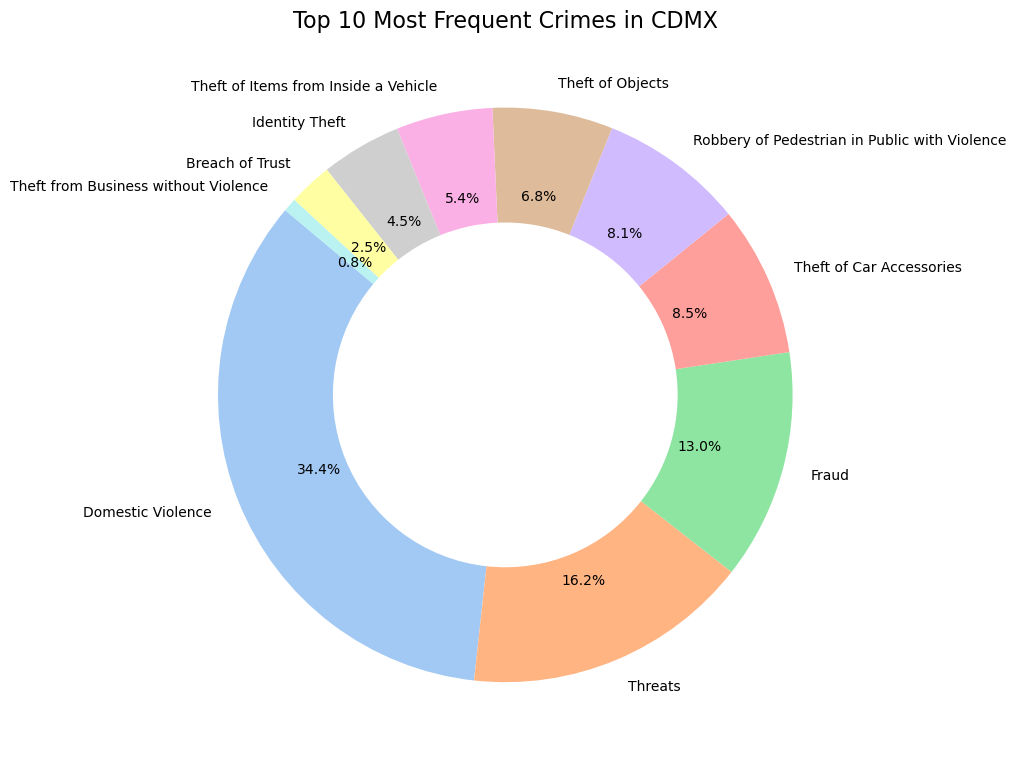

In [ ]:

# Calculate the count for each crime type
crime_counts = crime_data['crime'].value_counts()
total = crime_counts.sum()

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 10))
colors = sns.color_palette('pastel')

# Create the pie chart
wedges, texts = ax.pie(
    crime_counts,
    labels=crime_counts.index,
    colors=colors,
    startangle=140,
    wedgeprops=dict(width=0.4)  # Donut effect
)

# Calculate and add the percentages manually
for wedge, count in zip(wedges, crime_counts):
    # Compute the angle of the current wedge
    angle = (wedge.theta2 + wedge.theta1) / 2
    x = 0.7 * np.cos(np.radians(angle))  # Adjust the multiplier for position
    y = 0.7 * np.sin(np.radians(angle))

    # Annotate the percentage
    ax.annotate(
        f"{(count / total) * 100:.1f}%",
        xy=(x, y),
        ha='center',
        va='center',
        fontsize=10,
        color='black'
    )

# Add a title
ax.set_title("Top 10 Most Frequent Crimes in CDMX", fontsize=16)

# Show the plot
plt.tight_layout()
plt.show()




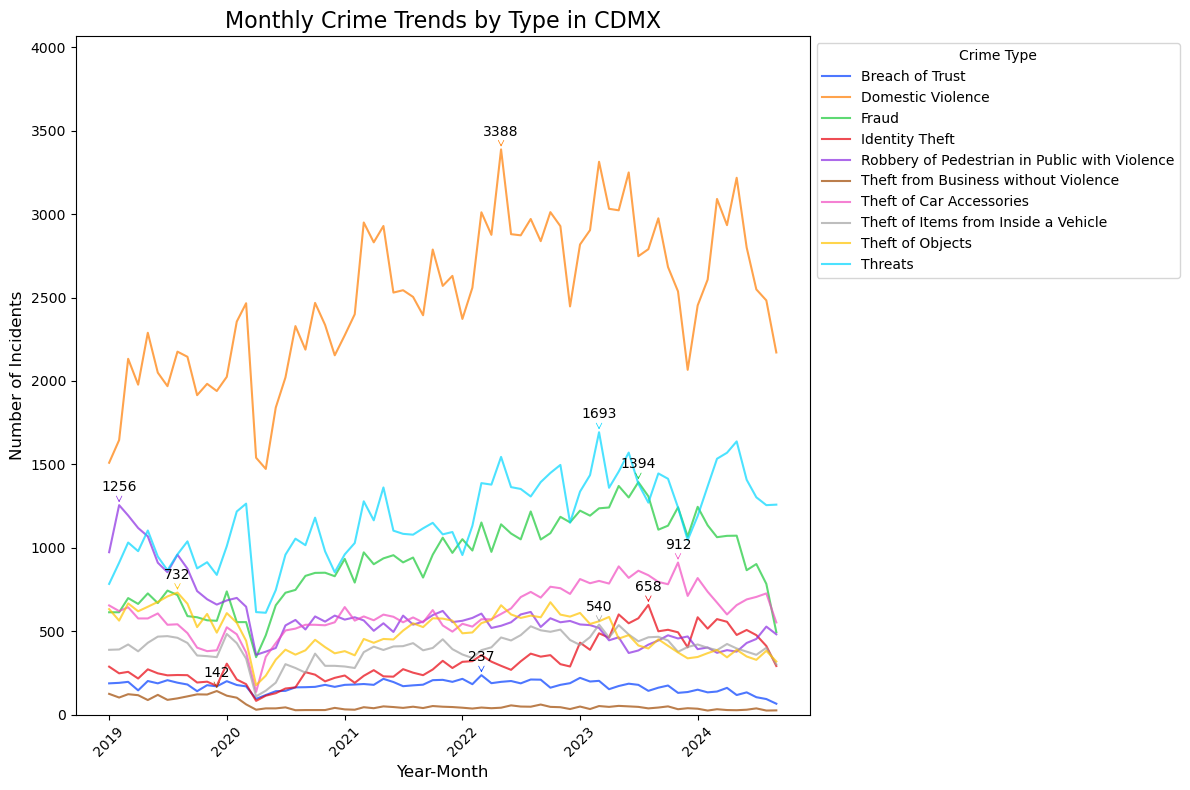

In [ ]:
# Plotting the Monthly Crime Trends in the city


# grouping a montly format
crime_data['year_month'] = crime_data['incident_date'].dt.to_period('M').dt.to_timestamp()

# Group by year_month and crime to get monthly counts
monthly_counts = crime_data.groupby(['year_month', 'crime']).size().reset_index(name='count')

# Filter data for the years 2019 to 2024
monthly_counts = monthly_counts[
    (monthly_counts['year_month'] >= '2019-01-01') & (monthly_counts['year_month'] <= '2024-10-31')
]

# Set up the figure
plt.figure(figsize=(12, 8))

# Plot each crime type
palette = sns.color_palette('bright')
crimes = monthly_counts['crime'].unique()

for i, crime in enumerate(crimes):
    crime_data_subset = monthly_counts[monthly_counts['crime'] == crime]

    # Plot the crime trend
    sns.lineplot(
        data=crime_data_subset,
        x='year_month',
        y='count',
        label=crime,
        color=palette[i % len(palette)],
        alpha=0.7
    )

    # Annotate the maximum point
    max_point = crime_data_subset.loc[crime_data_subset['count'].idxmax()]
    plt.annotate(
        f"{max_point['count']}",
        (max_point['year_month'], max_point['count']),
        textcoords="offset points",
        xytext=(0, 10),
        ha='center',
        arrowprops=dict(arrowstyle="->", lw=0.5, color=palette[i % len(palette)])
    )

# layout customizing
plt.title('Monthly Crime Trends by Type in CDMX', fontsize=16)
plt.xlabel('Year-Month', fontsize=12)
plt.ylabel('Number of Incidents', fontsize=12)
plt.xticks(rotation=45)
plt.ylim(0, monthly_counts['count'].max() * 1.2)
plt.legend(title='Crime Type', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()

plt.show()



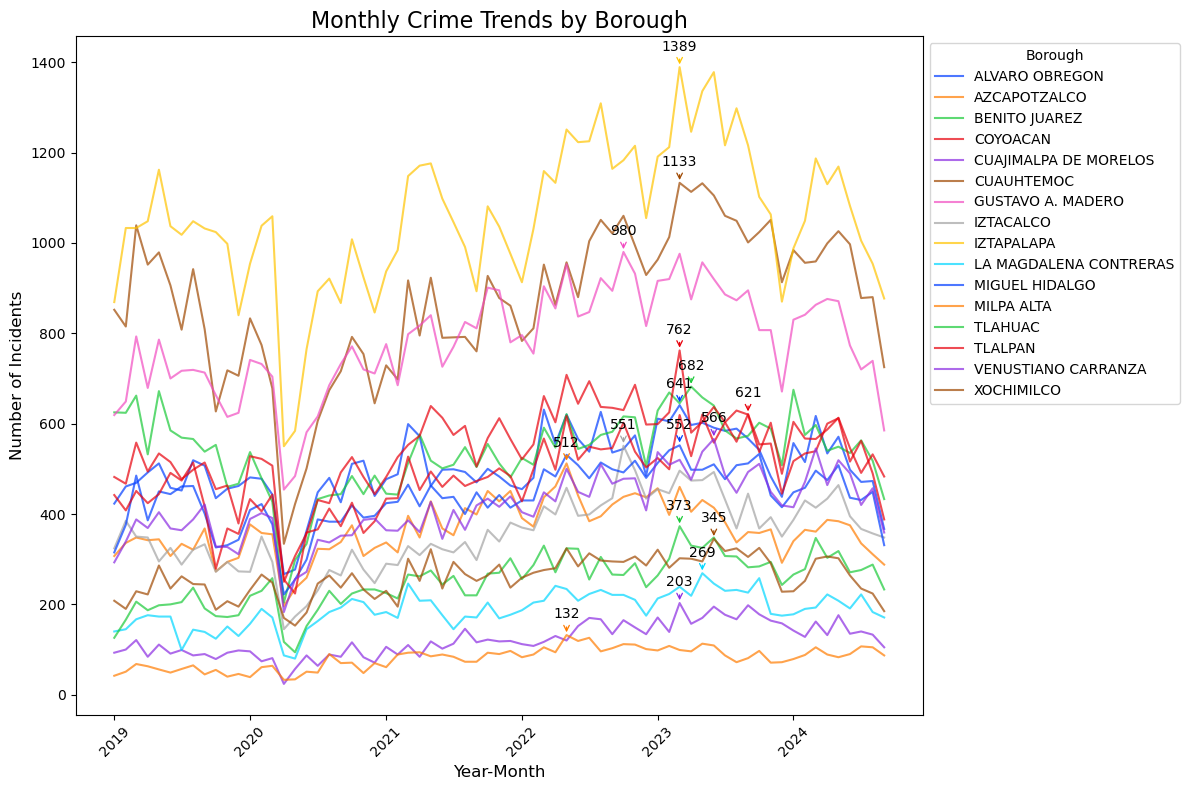

In [ ]:
# Plotting evolution of Monthly Crime trends

# Grouping by year_month and incident_borough
borough_trends = crime_data.groupby(['year_month', 'incident_borough']).size().reset_index(name='count')

# Filter data for the years 2019 to 2024
borough_trends = borough_trends[
    (borough_trends['year_month'] >= '2019-01-01') & (borough_trends['year_month'] <= '2024-10-31')
]

# Set up the figure
plt.figure(figsize=(12, 8))
palette = sns.color_palette('bright')

# Plot each borough trend and annotate the maximum point
boroughs = borough_trends['incident_borough'].unique()

for i, borough in enumerate(boroughs):
    # Subset data for the current borough
    borough_data = borough_trends[borough_trends['incident_borough'] == borough]

    # Plot the line for the borough
    sns.lineplot(
        data=borough_data,
        x='year_month',
        y='count',
        label=borough,
        color=palette[i % len(palette)],
        alpha=0.7
    )

    # Find and annotate the maximum point
    max_point = borough_data.loc[borough_data['count'].idxmax()]
    plt.annotate(
        f"{max_point['count']}",
        (max_point['year_month'], max_point['count']),
        textcoords="offset points",
        xytext=(0, 12),
        ha='center',
        arrowprops=dict(arrowstyle="->", lw=0.9, color=palette[i % len(palette)])
    )

# layout customizing
plt.title('Monthly Crime Trends by Borough', fontsize=16)
plt.xlabel('Year-Month', fontsize=12)
plt.ylabel('Number of Incidents', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Borough', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()


plt.show()


*Analyzing crime trends by gender*

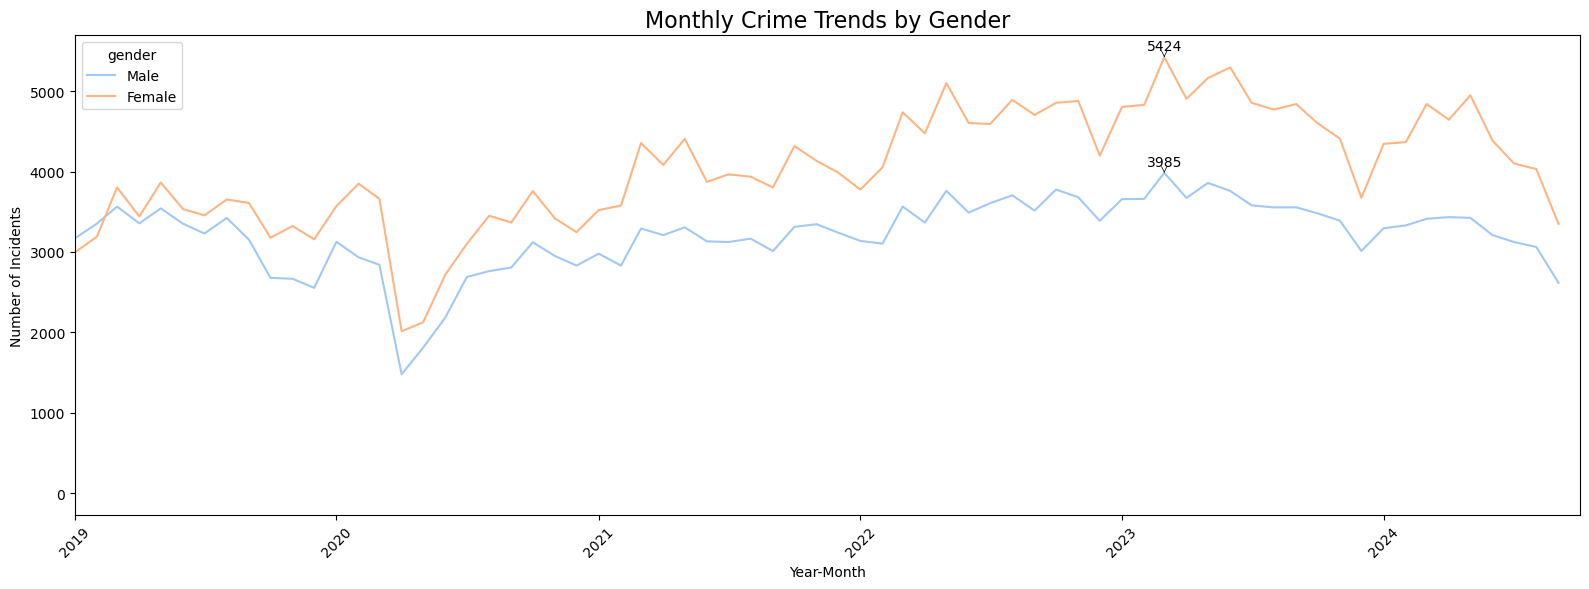

In [ ]:

# Group data by year_month and gender
gender_trends = crime_data.groupby(['year_month', 'gender']).size().reset_index(name='count')


plt.figure(figsize=(16, 6))
sns.lineplot(
    data=gender_trends,
    x='year_month',
    y='count',
    hue='gender',
    palette=palette
)

# Annotate maximum points
for gender in gender_trends['gender'].unique():
    gender_data = gender_trends[gender_trends['gender'] == gender]
    max_point = gender_data.loc[gender_data['count'].idxmax()]
    plt.annotate(
        f"{max_point['count']}",
        xy=(max_point['year_month'], max_point['count']),
        textcoords="offset points",
        xytext=(0, 5),
        ha='center',
        arrowprops=dict(arrowstyle="->", lw=0.5, color='black')
    )

# Customize plot
plt.title('Monthly Crime Trends by Gender', fontsize=16)
plt.xlabel('Year-Month')
plt.ylabel('Number of Incidents')
plt.xlim(pd.to_datetime(['2019-01-01', '2024-10-01']))  # Add x-axis range
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

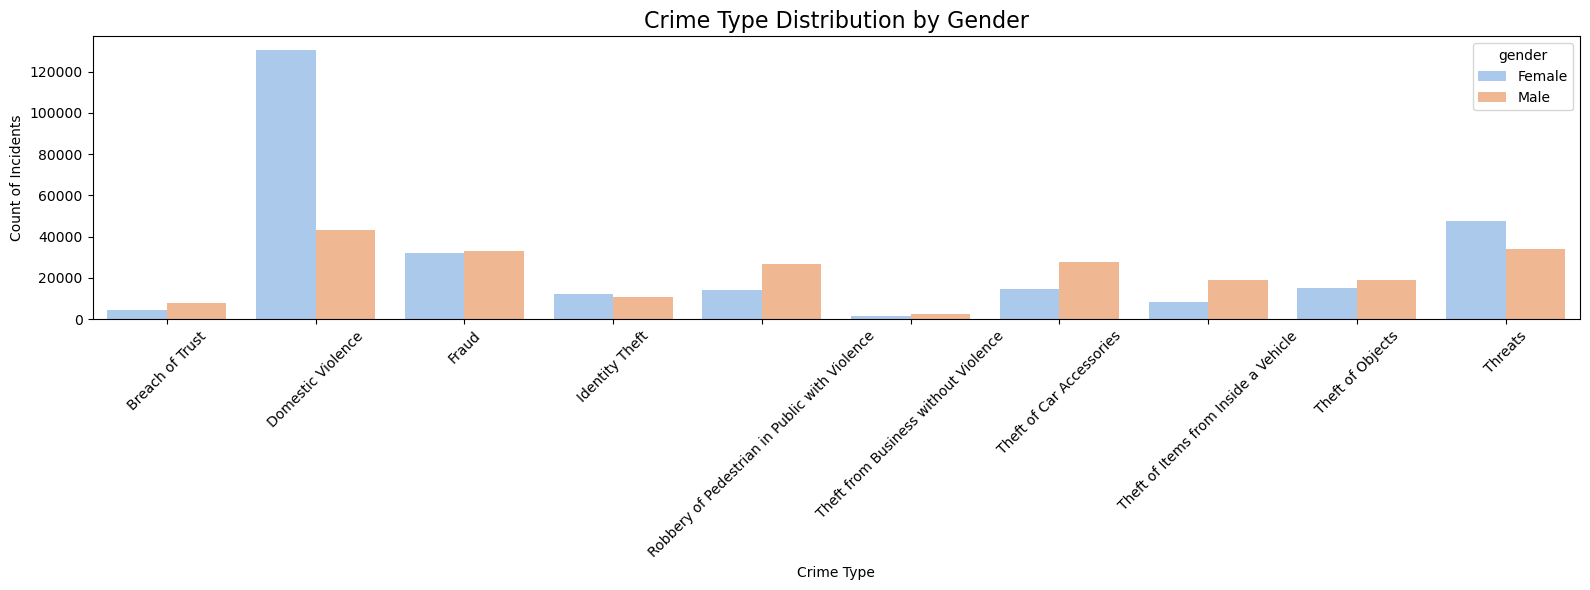

In [ ]:
# Group data by crime and gender
gender_crime_distribution = crime_data.groupby(['crime', 'gender']).size().reset_index(name='count')

# Plot
plt.figure(figsize=(16, 6))
sns.barplot(
    data=gender_crime_distribution,
    x='crime',
    y='count',
    hue='gender',
    palette=palette
)

# Customize plot
plt.title('Crime Type Distribution by Gender', fontsize=16)
plt.xlabel('Crime Type')
plt.ylabel('Count of Incidents')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


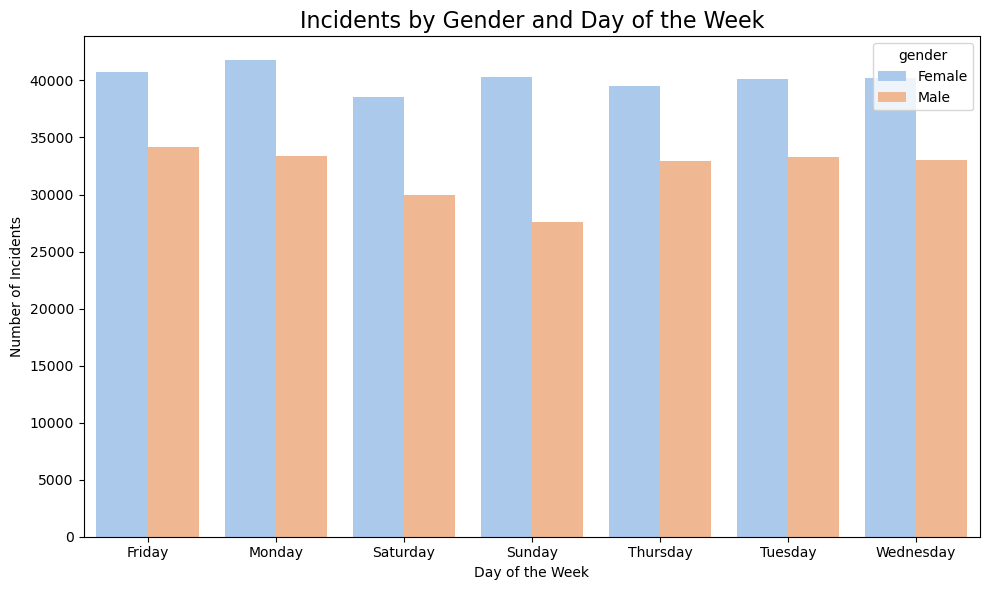

In [ ]:
# Group data by day_of_week and gender
day_gender_counts = crime_data.groupby(['day_of_week', 'gender']).size().reset_index(name='count')

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=day_gender_counts,
    x='day_of_week',
    y='count',
    hue='gender',
    palette=palette
)

# Customize plot
plt.title('Incidents by Gender and Day of the Week', fontsize=16)
plt.xlabel('Day of the Week')
plt.ylabel('Number of Incidents')
plt.tight_layout()
plt.show()


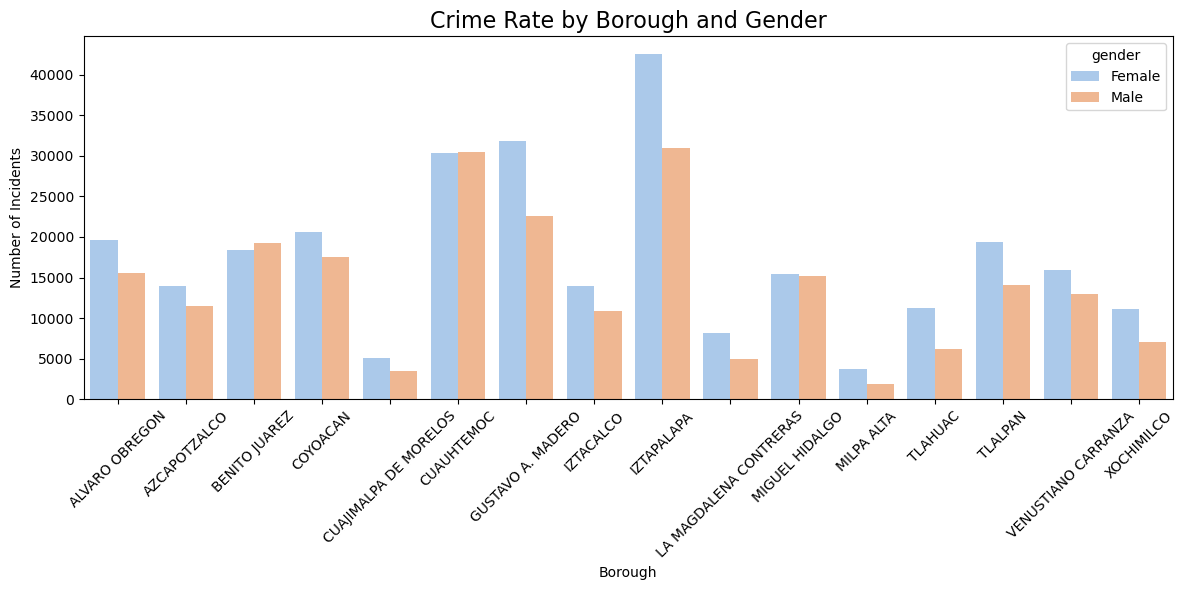

In [ ]:
# Group data by borough and gender
borough_gender_counts = crime_data.groupby(['incident_borough', 'gender']).size().reset_index(name='count')

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=borough_gender_counts,
    x='incident_borough',
    y='count',
    hue='gender',
    palette=palette
)

# Customize plot
plt.title('Crime Rate by Borough and Gender', fontsize=16)
plt.xlabel('Borough')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Modeling - Clustering Analysis for 2024
**Methodology**:
**Clustering Technique**: K-Means clustering was selected due to its efficiency in partitioning data based on spatial and categorical similarities, allowing for distinct groupings of crime incidents.

Identify Patterns: Group similar types of crime incidents based on characteristics such as location, crime type, and frequency. Clustering reveals hidden patterns that can help authorities understand which types of crimes are concentrated in specific areas and times.

**Support Targeted Interventions**: By recognizing patterns within clustering allows for tailored responses. Law enforcement can focus resources on specific regions and crime types, making prevention efforts more effective.

**Optimize Resource Allocation**: Clustering reveals crime "hotspots" and areas with high crime diversity, allowing authorities to allocate resources (patrols, surveillance) to areas most in need, while ensuring public safety.

**Guide Policy and Community Programs**: Insights from clusters can inform the development of community programs (financial literacy in fraud-prone areas) and influence policy decisions tailored to the needs of each region.

**Enhance Predictive Analysis**: Clusters provide a basis for future predictive analysis, enabling law enforcement to anticipate crime trends and take proactive steps in high-risk areas.


**Variables selected for clustering**
* Crime: Understanding what types of crimes are more prevalent.
* Location: Identifying specific boroughs and hotspots where crimes are more likely to occur.
* Time (day of the week): Recognizing weekly patterns in crime, which supports temporal resource planning.

By clustering with these features, we can derive insights into how crime types, locations, and temporal factors intersect, providing a foundation for targeted crime prevention strategies in Mexico City.

In [ ]:
# we filter the data to only include records from 2024
crime_data_2024 = crime_data[crime_data['incident_year'] == 2024]

In [ ]:

# select relevant features for clustering
data = crime_data_2024[['crime', 'incident_borough', 'latitude', 'longitude', 'day_of_week']]

# Encode categorical variables
label_encoders = {}
for column in ['crime', 'incident_borough', 'day_of_week']:
    le = LabelEncoder()
    le.fit(crime_data_2024[column])  # Fit on the full data to capture all possible categories
    data[column] = le.transform(data[column])   # Encode selected data for clustering
    label_encoders[column] = le


# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)


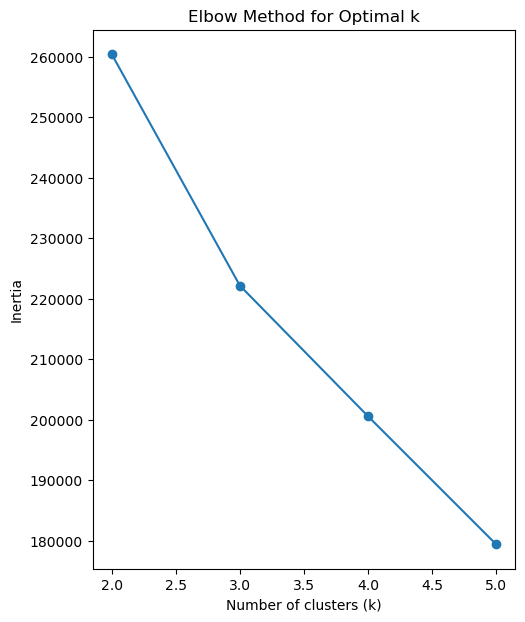

In [ ]:

# Determinign the optimal number of clusters using the elbow method
inertia = []
sil_scores = []
range_n_clusters = range(2, 6)
for k in range_n_clusters:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(scaled_data, kmeans.labels_))

plt.figure(figsize=(12, 7))

# Elbow Method
plt.subplot(1, 2, 1)
plt.plot(range_n_clusters, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')


plt.show()


In [ ]:
optimal_k = 3  # based on the graph done before
kmeans = KMeans(n_clusters=optimal_k, random_state=0) #Kmeans setting and random state seed
data['cluster'] = kmeans.fit_predict(scaled_data)


# Lets analyze clusters
clustered_data = pd.concat([crime_data_2024[['crime', 'incident_borough', 'latitude', 'longitude']], data['cluster']], axis=1)
clustered_data.head(10)


crime incident_borough  \
433311  Robbery of Pedestrian in Public with Violence         COYOACAN   
433313                       Theft of Car Accessories       CUAUHTEMOC   
433314                                        Threats          TLALPAN   
433316  Robbery of Pedestrian in Public with Violence          TLAHUAC   
433317           Theft of Items from Inside a Vehicle       IZTAPALAPA   
433318           Theft of Items from Inside a Vehicle   MIGUEL HIDALGO   
433319                                        Threats          TLAHUAC   
433320                       Theft of Car Accessories        IZTACALCO   
433326                               Theft of Objects          TLALPAN   
433328                                          Fraud    BENITO JUAREZ   

         latitude  longitude  cluster  
433311  19.321407 -99.172310        0  
433313  19.406539 -99.127682        2  
433314  19.232057 -99.213163        1  
433316  19.288396 -99.053909        1  
433317  19.323027 -99.100824        2  
433318  19.405571 -99.196361        2  
433319  19.291012 -99.052771        1  
433320  19.396460 -99.128669        2  
433326  19.225335 -99.211645        1  
433328  19.386536 -99.164312        0

In [ ]:
# proeloading the coordinates for Mexico City
map_clusters = folium.Map(location=[19.4326, -99.1332], zoom_start=10)

# Colors for each of the clusters
colors = ['red', 'blue', 'green', 'purple']
color_mapping = {i: colors[i % len(colors)] for i in clustered_data['cluster'].unique()}

# Add separate layers for each cluster with markers
for cluster_num in clustered_data['cluster'].unique():
    cluster_layer = folium.FeatureGroup(name=f'Cluster {cluster_num}')
    cluster_data = clustered_data[clustered_data['cluster'] == cluster_num]
    marker_cluster = MarkerCluster().add_to(cluster_layer)

    for _, row in cluster_data.iterrows():
        if pd.notnull(row['latitude']) and pd.notnull(row['longitude']):
            folium.Marker(
                location=[row['latitude'], row['longitude']],
                popup=f"Crime: {row['crime']}<br>Borough: {row['incident_borough']}",
                icon=folium.Icon(color=color_mapping[cluster_num])
            ).add_to(marker_cluster)

    cluster_layer.add_to(map_clusters) # added the layers for each cluster

# Added a heatmap layer
heatmap_layer = folium.FeatureGroup(name='Crime Heatmap')
heatmap_data = [[row['latitude'], row['longitude']] for _, row in clustered_data.iterrows() if pd.notnull(row['latitude']) and pd.notnull(row['longitude'])]
HeatMap(heatmap_data, radius=10).add_to(heatmap_layer)
heatmap_layer.add_to(map_clusters)

# layer control to toggle each cluster layer and heatmap visibility
folium.LayerControl().add_to(map_clusters)

# Save the map to an HTML file
map_clusters.save("cdmx_crime_clusters_mapping.html")


# Analysing Model Results

## FOLIUM HEATMAP - ALL LAYERS ACTIVATED
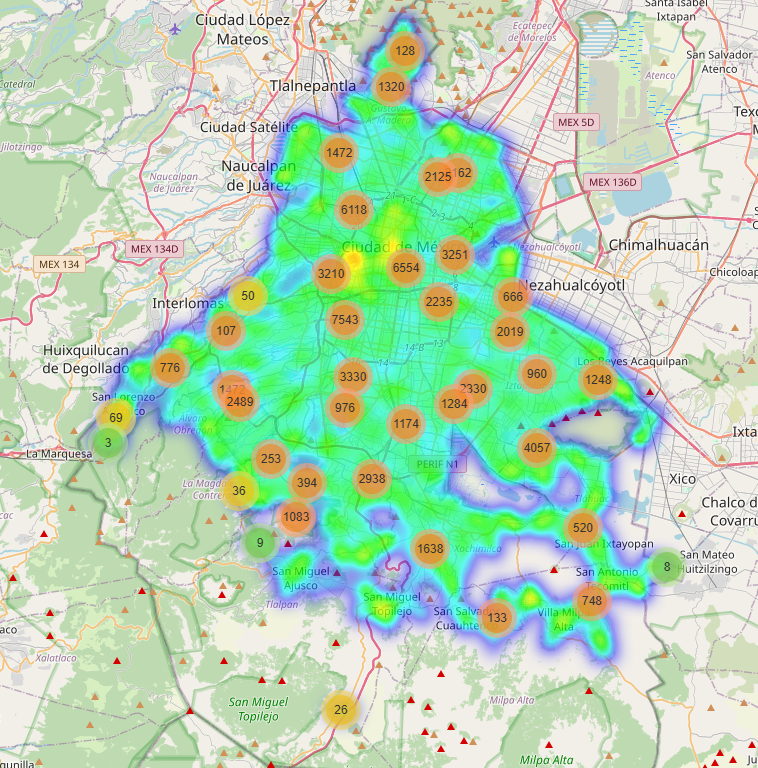

### CLUSTER 0 LAYER
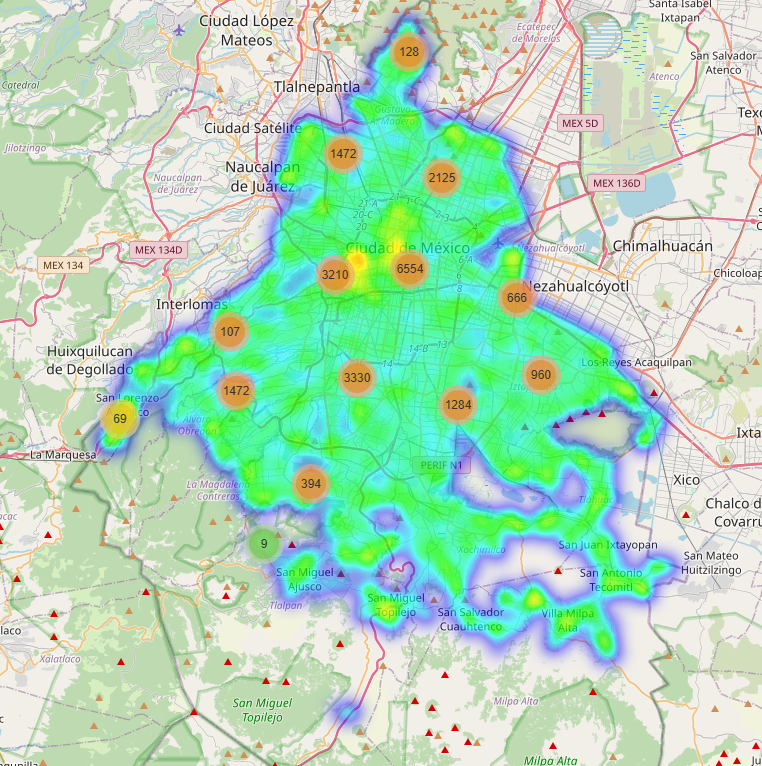


### CLUSTER 1 LAYER
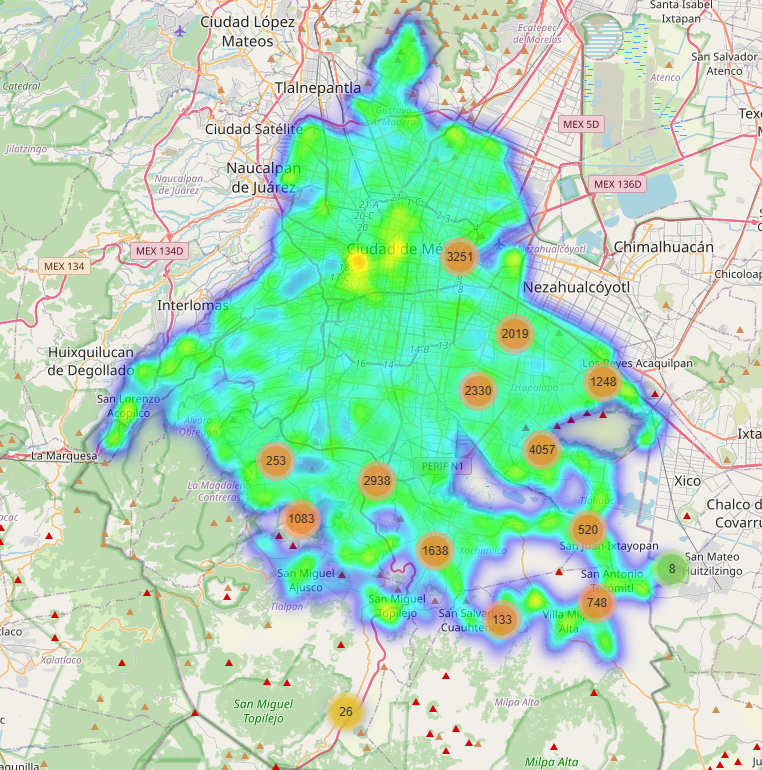

### CLUSTER 2 LAYER
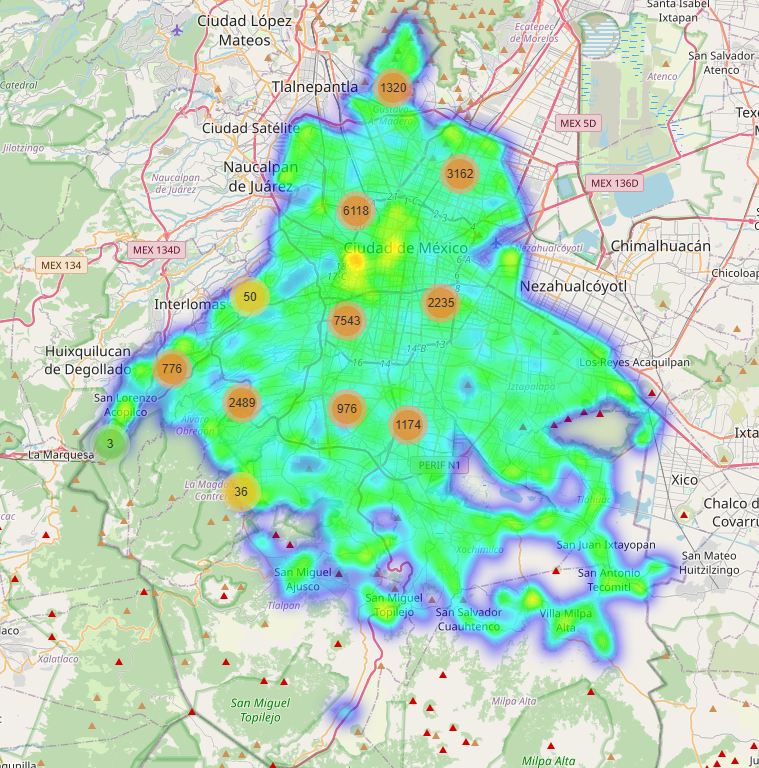

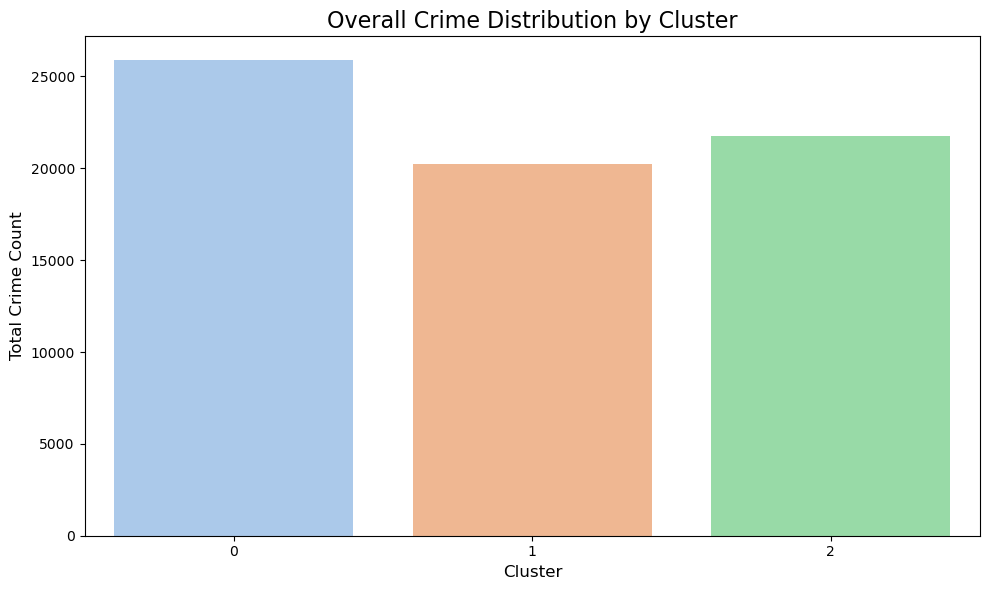

In [ ]:
# Overall Crime Distribution by Cluster
cluster_counts = clustered_data['cluster'].value_counts().reset_index()
cluster_counts.columns = ['cluster', 'count']

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=cluster_counts,
    x='cluster',
    y='count',
    palette='pastel'
)

# Customize the plot
plt.title("Overall Crime Distribution by Cluster", fontsize=16)
plt.xlabel("Cluster", fontsize=12)
plt.ylabel("Total Crime Count", fontsize=12)
plt.tight_layout()
plt.show()


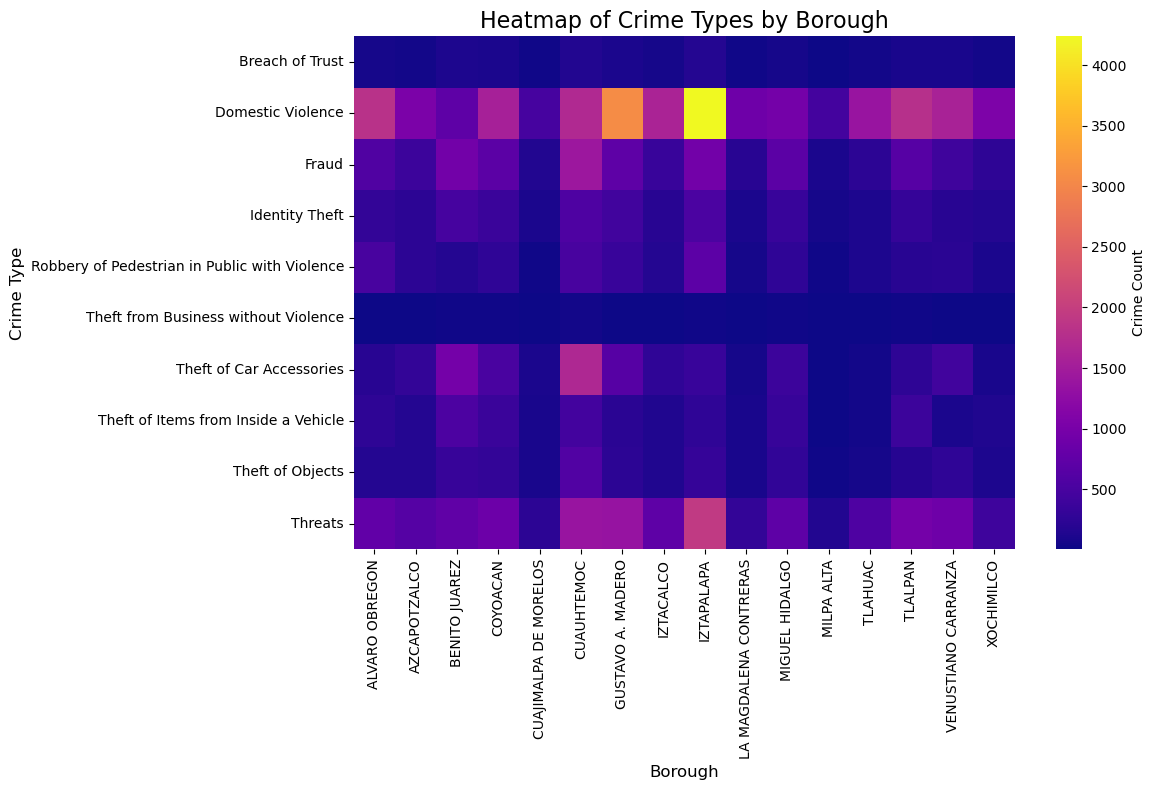

In [ ]:
# heatmap of cryme types by borough
crime_borough_counts = clustered_data.groupby(['incident_borough', 'crime']).size().reset_index(name='count')
heatmap_data = crime_borough_counts.pivot(index='crime', columns='incident_borough', values='count').fillna(0)

# Plot
plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_data,
    cmap='plasma',
    annot=False,
    cbar_kws={'label': 'Crime Count'}
)

# Customize the plot
plt.title("Heatmap of Crime Types by Borough", fontsize=16)
plt.xlabel("Borough", fontsize=12)
plt.ylabel("Crime Type", fontsize=12)
plt.tight_layout()
plt.show()


In [ ]:
# Get all unique crime types and create a consistent color mapping
unique_crimes = clustered_data['crime'].unique()
crime_colors = sns.color_palette('Paired', len(unique_crimes))
color_mapping = dict(zip(unique_crimes, crime_colors))


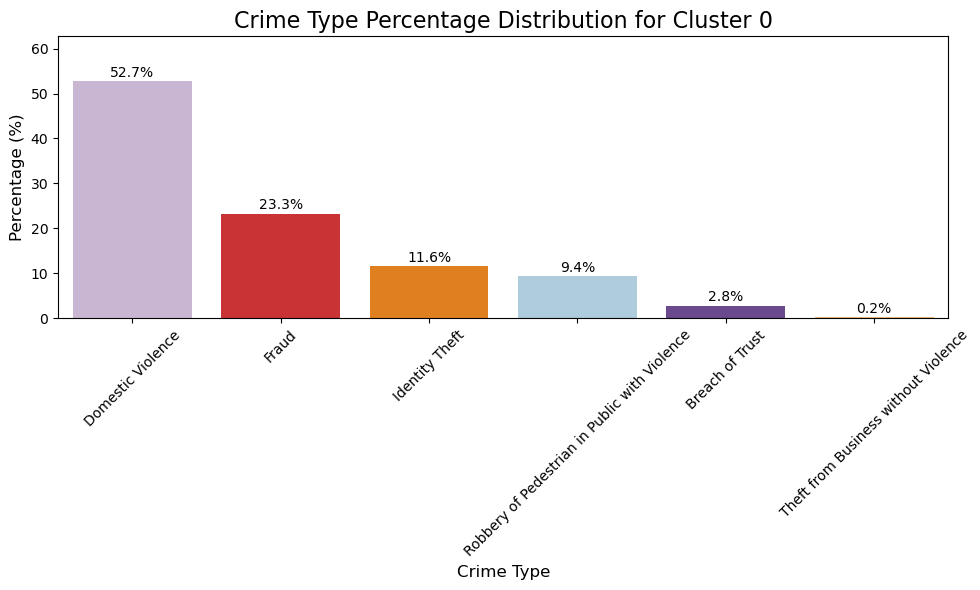

In [ ]:
# Filter data for Cluster 0 and calculate percentages
cluster_0_data = clustered_data[clustered_data['cluster'] == 0]
crime_counts_0 = cluster_0_data['crime'].value_counts(normalize=True) * 100

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    x=crime_counts_0.index,
    y=crime_counts_0.values,
    palette=[color_mapping[crime] for crime in crime_counts_0.index]
)

# Annotate percentages
for i, v in enumerate(crime_counts_0.values):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center', fontsize=10)

# Customize the plot
plt.title("Crime Type Percentage Distribution for Cluster 0", fontsize=16)
plt.xlabel("Crime Type", fontsize=12)
plt.ylabel("Percentage (%)", fontsize=12)
plt.xticks(rotation=45)
plt.ylim(0, max(crime_counts_0.values) + 10)  # Add space for annotations
plt.tight_layout()
plt.show()




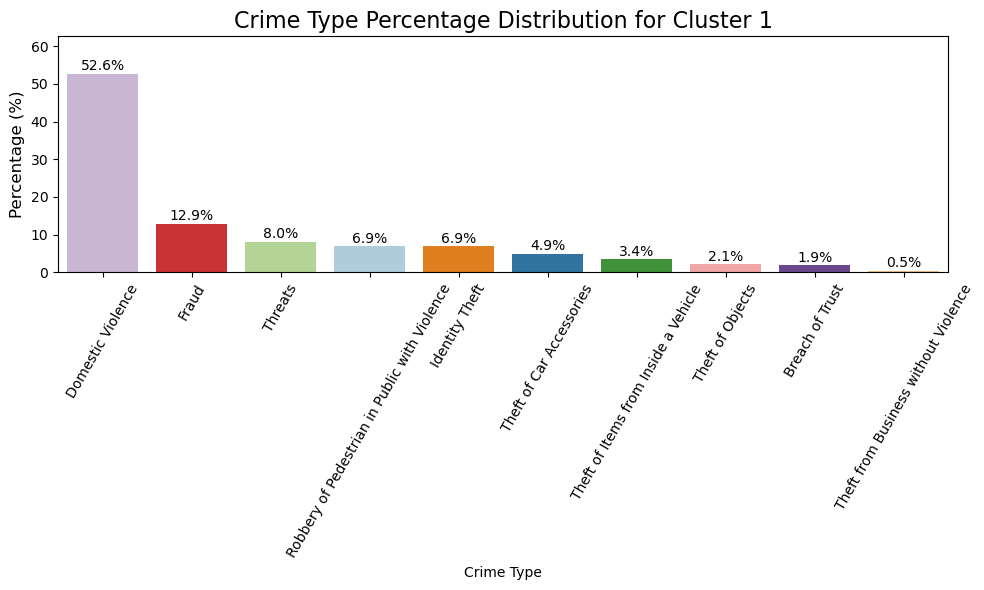

In [ ]:
# Filter data for Cluster 1 and calculate percentages
cluster_1_data = clustered_data[clustered_data['cluster'] == 1]
crime_counts_1 = cluster_1_data['crime'].value_counts(normalize=True) * 100

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    x=crime_counts_1.index,
    y=crime_counts_1.values,
    palette=[color_mapping[crime] for crime in crime_counts_1.index]
)

# Annotate percentages
for i, v in enumerate(crime_counts_1.values):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center', fontsize=10)

# Customize the plot
plt.title("Crime Type Percentage Distribution for Cluster 1", fontsize=16)
plt.xlabel("Crime Type", fontsize=10)
plt.ylabel("Percentage (%)", fontsize=12)
plt.xticks(rotation=60)
plt.ylim(0, max(crime_counts_1.values) + 10)  # Add space for annotations
plt.tight_layout()
plt.show()




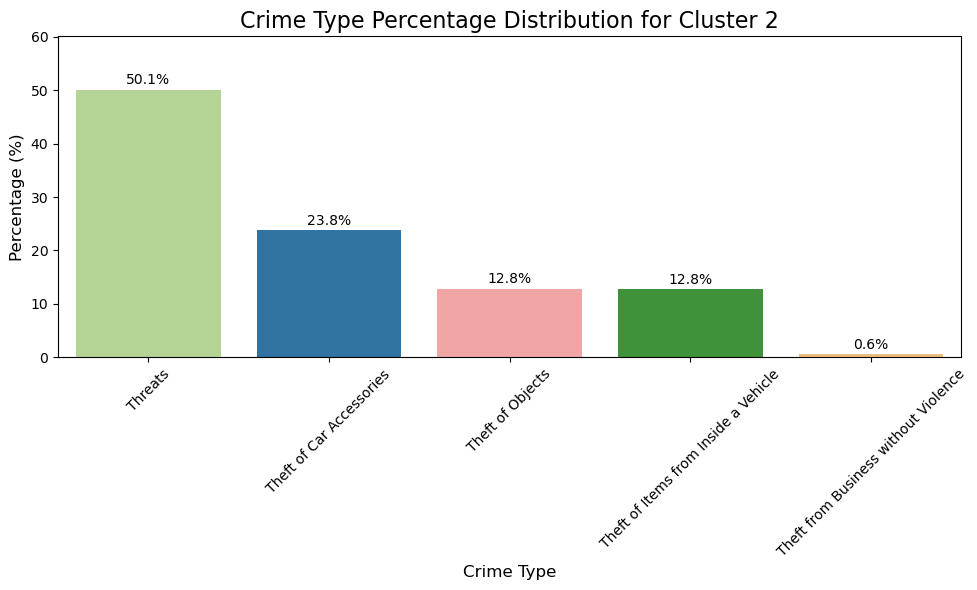

In [ ]:
# Filter data for Cluster 2 and calculate percentages
cluster_2_data = clustered_data[clustered_data['cluster'] == 2]
crime_counts_2 = cluster_2_data['crime'].value_counts(normalize=True) * 100

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    x=crime_counts_2.index,
    y=crime_counts_2.values,
    palette=[color_mapping[crime] for crime in crime_counts_2.index]
)

# Annotate percentages
for i, v in enumerate(crime_counts_2.values):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center', fontsize=10)

# Customize the plot
plt.title("Crime Type Percentage Distribution for Cluster 2", fontsize=16)
plt.xlabel("Crime Type", fontsize=12)
plt.ylabel("Percentage (%)", fontsize=12)
plt.xticks(rotation=45)
plt.ylim(0, max(crime_counts_2.values) + 10)  # Add space for annotations
plt.tight_layout()
plt.show()



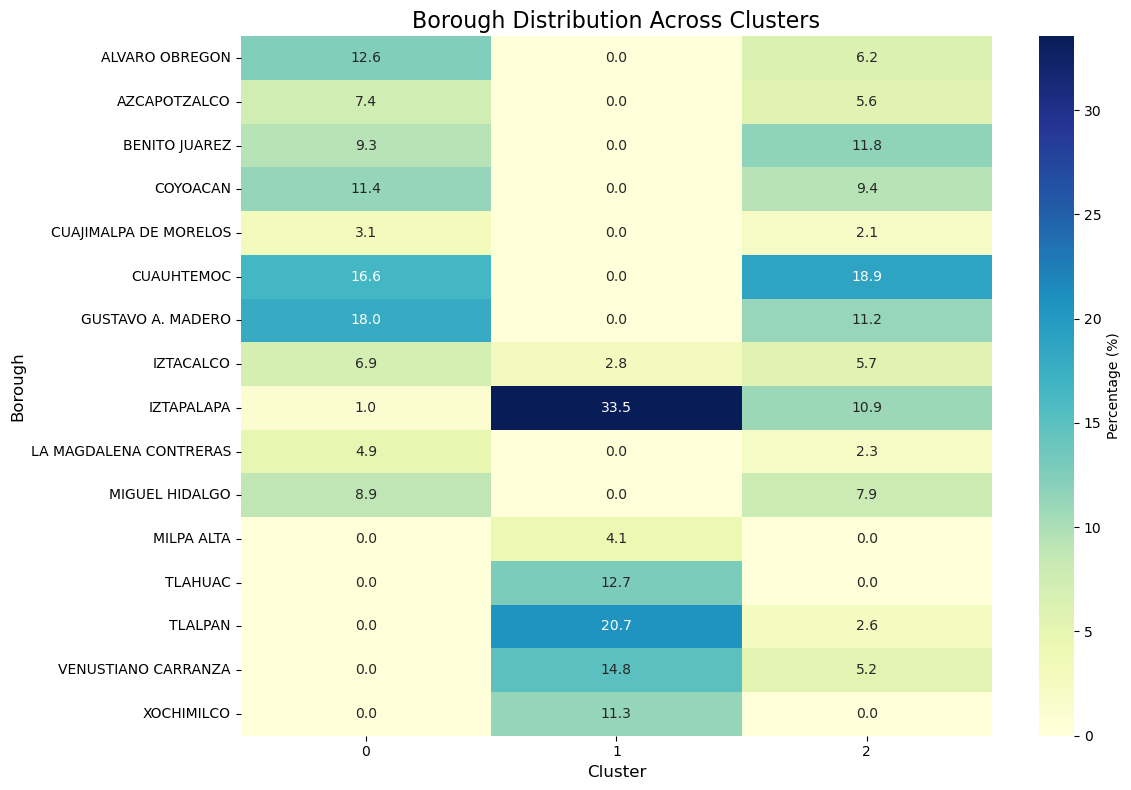

In [ ]:
# Count occurrences of boroughs by cluster
borough_cluster_counts = clustered_data.groupby(['cluster', 'incident_borough']).size().reset_index(name='count')


# Calculate percentages for boroughs within each cluster
borough_cluster_counts['percentage'] = (
    borough_cluster_counts.groupby('cluster')['count']
    .apply(lambda x: (x / x.sum()) * 100)
)


# Pivot the data for a heatmap
heatmap_data = borough_cluster_counts.pivot(index='incident_borough', columns='cluster', values='percentage').fillna(0)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".1f",
    cmap='YlGnBu',
    cbar_kws={'label': 'Percentage (%)'}
)

# Customize the plot
plt.title("Borough Distribution Across Clusters", fontsize=16)
plt.xlabel("Cluster", fontsize=12)
plt.ylabel("Borough", fontsize=12)
plt.tight_layout()
plt.show()



In [ ]:
# Group by cluster and borough, and calculate percentages
borough_cluster_counts = (
    clustered_data.groupby(['cluster', 'incident_borough'])
    .size()
    .reset_index(name='count')
)

# Calculate percentages for each borough within each cluster
borough_cluster_counts['percentage'] = (
    borough_cluster_counts.groupby('cluster')['count']
    .apply(lambda x: (x / x.sum()) * 100)
)

# Extract the top 4 boroughs for each cluster
top_boroughs_per_cluster = borough_cluster_counts.sort_values(
    ['cluster', 'percentage'], ascending=[True, False]
).groupby('cluster').head(4)

# Display the result
top_boroughs_per_cluster[['cluster', 'incident_borough', 'percentage']]


cluster     incident_borough  percentage
6         0    GUSTAVO A. MADERO   17.983778
5         0           CUAUHTEMOC   16.597142
0         0       ALVARO OBREGON   12.572422
3         0             COYOACAN   11.359598
12        1           IZTAPALAPA   33.534176
15        1              TLALPAN   20.658831
16        1  VENUSTIANO CARRANZA   14.806401
14        1              TLAHUAC   12.741999
23        2           CUAUHTEMOC   18.860213
20        2        BENITO JUAREZ   11.788207
24        2    GUSTAVO A. MADERO   11.214181
26        2           IZTAPALAPA   10.938648

# **Final conclusion for Security Strategy Improvement in Mexico City by Uncovering Key Patterns**


## **Cluster 0: Domestic Violence, Fraud, and Identity Theft**
- **Key Boroughs**: Gustavo A Madero, Cuauhtémoc, Álvaro Obregón, Coyoacán

#### **Strategic Actions**
**Address Domestic Violence Systematically**
   - Establish **accessible support centers** providing family counseling, legal aid, and emergency shelters for victims of domestic violence
   - Deploy **community-led patrols** to prevent domestic disputes from escalating in high-risk neighborhoods

 **Combat Fraud and Identity Theft**
   - Launch **financial literacy campaigns** and cybersecurity workshops in public spaces to educate residents
   - Strengthen **fraud reporting mechanisms** through a streamlined hotline and police collaboration

 **Targeted Police Deployment**
   - Increase the presence of law enforcement trained to hndle domestic issues in **Gustavo A Madero** and **Cuauhtémoc**
   - Use neighborhood-level data to identify repeat offenders and protect vulnerable populations

---

## **Cluster 1: Domestic Violence, Theft, Threats, and Fraud**
- **Key Boroughs**: Iztapalapa, Tlalpan, Venustiano Carranza, Tláhuacc

#### **Strategic Actions**
**Intervene in Vulnerable Communities**
   - Expand **mental health services** and conflict resolution programs, particularly in **Iztapalapa**, to address underlying causes of domestic violence
   - Introduce **youth engagement programs** to reduce cycles of violence and theft

 **Strengthen Public Safety**
   - Install **CCTV cameras** and improve lighting in public spaces, especially transit hubs and marketplaces in **Tláhuac** and **Venustiano Carranza**
   - Train **rapid response police units** to address public threats and robberies effectively.

 **Prevent Diverse Thefts**
   - Collaborate with local businesses to create **secure storage solutions** for personal belongings and promote **community watch programs** in residential Boroughs

---

## **Cluster 2: Threats and Theft in Economic Boroughs**
- **Key Boroughs**: Cuauhtémoc, Benito Juárez, Gustavo A Madero, Iztapalapa

#### **Strategic Actions**
**Enhance Security for Economic Boroughs**
   - Deploy **undercover patrols** and mobile surveillance units in commercial zones to prevent theft
   - Collaborate with business owners to improve security systems in **Cuauhtémoc** and **Benito Juárez**

 **Improve Infrastructure to Prevent Theft**
   - Develop **secure parking zones** and encourage vehicle owners to adopt anti-theft technologies
   - Install smart surveillance systems in **economic hubs** like **Benito Juárez**

 **Community Partnerships**
   - Work with neighborhood associations to implement **vigilance programs** in Boroughs like **Gustavo A Madero** and **Iztapalapa**, focusing on theft prevention

---

## **Citywide Measures**
**Dynamic Resource Allocation**
   - Use data from cluster analysis to **deploy police and resources** where they are needed most, with regular updates based on crime trends

 **Integrated Reporting Systems**
   - Launch a centralized crime reporting platform accessible via a mobile app to improve coordination between law enforcement and community members

 **Public Awareness Campaigns**
   - Educate residents on fraud prevention, domestic violence reporting, and theft protection through borough-specific initiatives

4 **Collaboration Across Sectors**
   - Partner with local governments, NGOs, and businesses to address socioeconomic vulnerabilities contributing to crime

---

## **Mission**
By adressing this problem with this enformation we are enhancing the true power of machine learning by uncovering hidden insights to take data-driven decisions to one of CDMX critical problems, each cluster at a time we can transform peoples lives, strive for a better future. Cluster 0 prioritizes domestic violence prevention and fraud awareness, Cluster 1 focuses on public safety in vulnerable zones, and Cluster 2 secures economic areas against theft and threats. Together, these initiatives create a cohesive environment not onluy for residents but also for evryone that chooses to experience this wonderful city making it a safer place for all.


*Made by: Victor Manuel Torres Vega*